In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns
import numpy as np
from scipy import stats, spatial
import processing

In [3]:
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics
import statsmodels.api as sm

## Performance analysis

### Data prep

In [4]:
words = pd.read_csv('./data/words.csv')

In [5]:
log = pd.read_csv('./data/log_valid_processed.csv')

In [6]:
participants = pd.read_csv('./data/participants_processed.csv',index_col=0)
participants = participants.loc[participants.index.isin(log.participant_id.unique())].copy()

In [7]:
mask = words.ite == 'none'
mask &= words.word_length < 5
mask &= words.freq_category == 'very_common'
mask &= words.iki_letters.notna()

participants['iki_natural'] = words.loc[mask].groupby('participant_id').iki_letters.mean()

# Letter-only speed
mask = words.ite == 'none'
participants['iki_letters'] = words.loc[mask].groupby('participant_id').iki_letters.mean()

# Letters and selection speed
participants['iki_letters_and_ite'] = words.groupby('participant_id').iki_letters_and_ite.mean() 

# Overall speed
iki_overall = log.groupby(['participant_id','ts_id']).iki.sum() / log.groupby(['participant_id','ts_id']).text_field.last().str.len()
iki_overall = iki_overall.reset_index(name='iki').groupby('participant_id').iki.mean()
participants['iki_overall'] = iki_overall

# Remove NA speeds
participants = participants.dropna(subset=['iki_natural','iki_letters','iki_letters_and_ite','iki_overall']).copy()

# Remove extremely fast speeds (for example, due to outlier backend behaviour)
participants = participants.loc[participants.iki_natural > 75].copy()

# Calculate word suggestion usage
participants['n_predict'] = words.groupby('participant_id').ite.value_counts().unstack()['predict'].fillna(0)
participants['rate_predict'] = words.groupby('participant_id').ite.value_counts(normalize=True).unstack()['predict'].fillna(0)

# Calculate keystrokes per character
mask = log.lev_dist < 10 # Filter out poor LD calculations
participants['KPC'] = log.loc[mask].groupby('participant_id').size() / log.loc[mask].groupby('participant_id').lev_dist.sum()

# Separate into normal and suggestion users
participants.loc[participants.n_predict < 1,'user_type'] = 'Normal'
participants.loc[participants.n_predict > 5,'user_type'] = 'Suggestion users'

### How many users in each group?

In [8]:
participants.user_type.value_counts()

Suggestion users    2616
Normal              2296
Name: user_type, dtype: int64

### What is the mean natural speed of each group?

In [9]:
participants.groupby('user_type').iki_natural.mean().apply(np.reciprocal)*1000

user_type
Normal              5.424126
Suggestion users    4.753959
Name: iki_natural, dtype: float64

### How does suggestion usage affect typing speed?

In [10]:
# Prepare a display table. Will fill later.
disp = pd.DataFrame(    
    index = ['Normal users','Suggestion users','Difference (controlled for natural speed)'],
    columns=['Natural speed','Letter-only speed','Letter-and-selection speed','Overall speed']
)

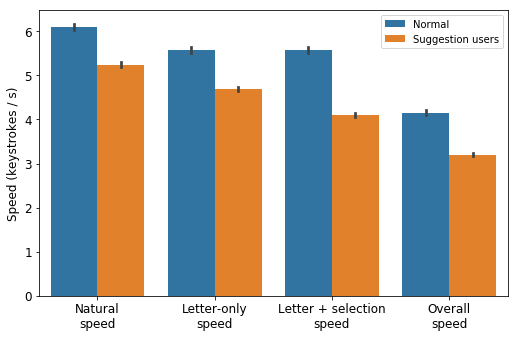

In [11]:
f,ax = plt.subplots(1,1,figsize=(7,4.5))

# Data prep
data = participants.copy()
data = data.loc[data.user_type.notna()]
data = data.loc[data.iki_natural.notna()]

data.iki_natural = data.iki_natural.apply(np.reciprocal)*1000 # Convert iki to speed
data.iki_overall = data.iki_overall.apply(np.reciprocal)*1000
data.iki_letters = data.iki_letters.apply(np.reciprocal)*1000
data.iki_letters_and_ite = data.iki_letters_and_ite.apply(np.reciprocal)*1000

data = data.sort_values('user_type')
data_melt = pd.melt(data[['user_type','iki_natural','iki_letters','iki_letters_and_ite','iki_overall']],id_vars='user_type') # Melt (easier to plot this way)

# Plot
sns.barplot('variable','value',hue='user_type',data=data_melt,ax=ax)

ax.set_xlabel('')
ax.set_xticklabels(['Natural\nspeed', 'Letter-only\nspeed','Letter + selection\nspeed','Overall\nspeed'])
ax.set_ylabel('Speed (keystrokes / s)')
ax.legend(title='User type')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax.legend(title='')

f.tight_layout(pad=0)

f.savefig('./figures/bar_typing_speeds.png', dpi=300)

In [12]:
# Display the means
res = data[[
    'user_type',
    'iki_natural',
    'iki_letters',
    'iki_letters_and_ite',
    'iki_overall'
]].groupby('user_type').mean().round(2)

disp.loc['Normal users'] = res.loc['Normal'].apply(str).values
disp.loc['Suggestion users'] = res.loc['Suggestion users'].apply(str).values

# Open parantheses
disp.loc['Normal users'] += '\n('
disp.loc['Suggestion users'] += '\n('

# Display the stderr
res = data[[
    'user_type',
    'iki_natural',
    'iki_letters',
    'iki_letters_and_ite',
    'iki_overall'
]].groupby('user_type').std().round(2)
disp.loc['Normal users'] += res.loc['Normal'].apply(str).values
disp.loc['Suggestion users'] += res.loc['Suggestion users'].apply(str).values

# Close parantheses
disp.loc['Normal users'] += ')'
disp.loc['Suggestion users'] += ')'

from IPython.display import display

# Display
display(disp.style.set_properties(**{
    'white-space': 'pre-wrap',
}))

,Natural speed,Letter-only speed,Letter-and-selection speed,Overall speed
Normal users,6.1 (1.81),5.58 (1.69),5.58 (1.68),4.16 (1.47)
Suggestion users,5.24 (1.44),4.69 (1.29),4.1 (1.21),3.2 (0.86)
Difference (controlled for natural speed),nan,nan,nan,nan


In [13]:

data = participants.dropna(subset=['user_type']).copy()
data['user_bool'] = data.user_type.map({'Normal': 0, 'Suggestion users': 1}) # convert to boolean (for OLS)
data.rate_predict = data.rate_predict.apply(np.reciprocal) # Reciprocal transform (otherwise data is not normally distributed)
data.iki_natural = data.iki_natural.apply(np.reciprocal) * 1000 # Convert to speed

# For each type of IKI, perform an OLS
for i in ['letters','letters_and_ite','overall']:
    data = data.dropna(subset=['iki_'+i,'rate_predict']) # Drop any nan
    data['speed'] = data['iki_'+i].apply(np.reciprocal) * 1000 # Convert to speed
    
    # Separate into X and y
    X = data[['user_bool','iki_natural']]
    X = sm.add_constant(X)
    y = data[['speed']]
    
    # OLS
    model = sm.OLS(y,X)
    results = model.fit()
    
    # Print results
    print()
    print(i)
    print('mag: ',results.params[1])
    print('std: ', results.bse[1])
    print('p: ', results.pvalues[1])
    print('r2: ',results.rsquared)


letters
mag:  -0.11958763189364728
std:  0.009623680434076874
p:  6.2697397531731e-35
r2:  0.9560624914874347

letters_and_ite
mag:  -0.7485161882465841
std:  0.012722275871930772
p:  0.0
r2:  0.929930645820532

overall
mag:  -0.42718804160006135
std:  0.018824002871494033
p:  1.659390614099466e-108
r2:  0.7523173307120645


### How does the extent of suggestion usage affect typing speed?

This is very similar to the previous analysis, except that instead if a boolean (suggestion vs. non-suggestion users), we have a continuous variabel representing the suggestion usage rate.

In [14]:
data = participants.loc[(participants.n_predict > 5) & (participants.n_predict < 20)].copy()
data.rate_predict = data.rate_predict.apply(np.reciprocal)
data.iki_natural = data.iki_natural.apply(np.reciprocal) * 1000

# For each type of IKI, perform an OLS
for i in ['natural','letters','letters_and_ite','overall']:
    data = data.dropna(subset=['iki_'+i,'rate_predict'])
    data['speed'] = data['iki_'+i].apply(np.reciprocal) * 1000 # Convert to speed
    
    X = data[['rate_predict','iki_natural']]
    X = sm.add_constant(X)
    y = data[['speed']]
    
    # OLS
    model = sm.OLS(y,X)
    results = model.fit()
    
    # Print results
    print()
    print(i)
    print('slope: ',results.params[1])
    print('std: ', results.bse[1])
    print('p: ', results.pvalues[1])
    print('r2: ',results.rsquared)


natural
slope:  -0.4496528180856348
std:  0.1510706787520185
p:  0.002947806615840723
r2:  0.7889945018547652

letters
slope:  0.005949399322118759
std:  0.0016548700466468788
p:  0.00033138588181907014
r2:  0.9238082448158167

letters_and_ite
slope:  0.05162257539674885
std:  0.0018130329280324992
p:  3.4470080727822987e-152
r2:  0.8844319458460106

overall
slope:  0.026786770357663716
std:  0.002631595296031193
p:  8.177505804394318e-24
r2:  0.5976504072637203


Visualize the regression we just did for overall speed

In [15]:
# Data prep
data = participants.loc[(participants.n_predict > 5) & (participants.n_predict < 20)].copy()
data['speed_overall'] = data.iki_overall.apply(np.reciprocal) * 1000
data.rate_predict = data.rate_predict.apply(np.reciprocal)

In [16]:
# OLS
slope,intercept, r, p, std = stats.linregress(data.rate_predict,data.speed_overall)
print(slope,std,p,r)

0.06561416464962021 0.003717638610890684 2.504315554139865e-65 0.3513408160296149


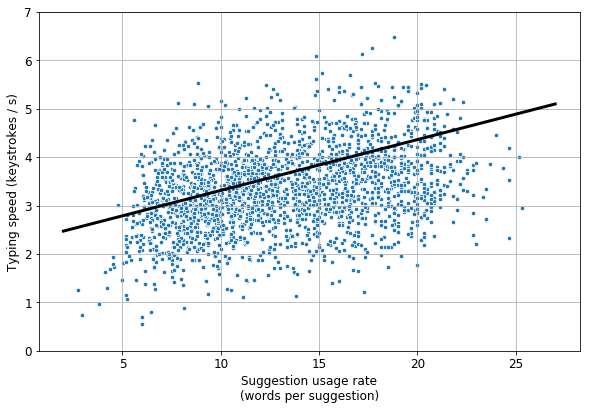

In [17]:
f,ax = plt.subplots(1,1,figsize=(8,5.5))

# Plot the points
sns.scatterplot('rate_predict','speed_overall',data=data,ax=ax,color='C0',s=20)

# Plot the regression line
sns.lineplot([2,27],[intercept,slope*40 + intercept],color='k',lw=3)

ax.set_ylim((0,7))
ax.set_xlabel('Suggestion usage rate\n(words per suggestion)')
ax.set_ylabel('Typing speed (keystrokes / s)')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax.grid()

f.tight_layout(pad=0)

f.savefig('./figures/regression_speed.png',dpi=300)

### How does the extent of usage affect KPC?

In [18]:
# Data prep
mask = (participants.n_predict > 5) # Only look at suggestion users
mask &= (participants.n_predict < 26) # Exclude heavy usage (not enough data)
data = participants.loc[mask].copy()

X = data.rate_predict
X = sm.add_constant(X)
y = data.KPC

In [19]:
# OLS
model = sm.OLS(y,X)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    KPC   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     2338.
Date:                Fri, 13 Sep 2019   Prob (F-statistic):               0.00
Time:                        12:00:35   Log-Likelihood:                 6238.1
No. Observations:                2397   AIC:                        -1.247e+04
Df Residuals:                    2395   BIC:                        -1.246e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.9937      0.001   1153.377      0.000       0.992       0.995
rate_predict    -0.3964      0.008    -48.352      0.000      -0.412      -0.380
==============================================================================
Omnibus:                     1936.261   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           204255.216
Skew:                          -3.155   Prob(JB):                         0.00
Kurtosis:                      47.781   Cond. No.                         22.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

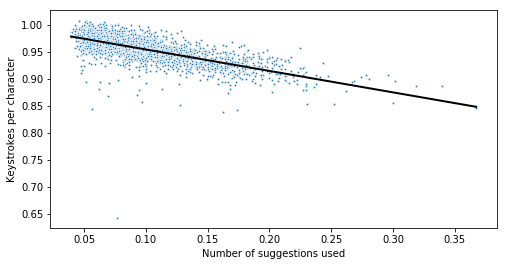

In [20]:
f,ax = plt.subplots(1,1,figsize=(8,4))

# Plot the points
ax = sns.scatterplot(data.rate_predict, data.KPC, color='C0',s=7)

# Plot the regression line
xmin = X.min()[1]
xmax = X.max()[1]
intercept, slope = results.params[0], results.params[1]
sns.lineplot([xmin,xmax],[slope*xmin + intercept,slope*xmax + intercept],color='k',lw=2)

ax.set_xlabel('Number of suggestions used')
ax.set_ylabel('Keystrokes per character')

f.savefig('./figures/regression_kpc.png',dpi=300)